# Intercomparison of cloud-top pressure distributions derived from satellite observations

Production date: 23-10-2024, modified 12-06-2025 and 25-09-2025, finalized 12-01-2026

Produced by: CNRS


## 🌍 Use case: Cloud-top pressure distributions over ocean and over land

## ❓ Quality assessment question:
 - __How does the cloud-top pressure distribution vary between climate zones, and how do the products of the Climate Data Store compare to other satellite retrievals?__



Clouds are fundamental regulators of the Earth's climate system, significantly influencing the planet's radiative budget, hydrological cycle, and global circulation. These factors, in turn, play a crucial role in shaping ecosystems, agriculture, water resources, and weather patterns. The overall impact of clouds on Earth's climate is determined by various cloud properties, including their amount, height, opacity, and their microphysical characteristics. Given their substantial influence on climate, cloud properties are extensively studied, both in the present context and in relation to their evolution under climate change.

High- and low-level clouds have distinct atmospheric radiative effects due to differences in temperature, opacity, and composition. High-level clouds strongly trap outgoing longwave infrared radiation from the Earth's surface, and they allow most shortwave solar radiation to pass when they are thin. This leads to a net warming effect on both the surface and the atmosphere. In contrast, low-levl clouds reflect a significant portion of incoming solar radiation back into space, producing a cooling effect.

The following notebook focuses on the cloud-top height, given as cloud-top pressure. High-level clouds are defined as clouds with a cloud-top pressure < 440 hPa. This corresponds to a height of about 7.3 km in the tropics and 6.6 km in the midlatitudes. Low-level clouds are defined as clouds with a cloud-top pressure > 680 hPa, corresponding to a height of about 3.5 km in the tropics and 3.3 km in the midlatitudes. The cloud-top pressure has been retrieved from the measured radiances. Cloud-top temperature and cloud-top height are derived from cloud-top pressure by using atmospheric profiles, obtained from meteorological reanalyses.


This analysis utilizes cloud observations from the dataset [__Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations__](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview), available at the Climate Data Store. Two complementary Thematic Climate Data Records of cloud properties are provided from two families: CLARA (CM SAF cLoud, Albedo and surface Radiation) and CCI (Climate Change Initiative). These data differ in temporal sampling and horizontal resolution as well as in applied retrieval methods. ___Recently, the retrieval version CLARA-A2 has been replaced by CLARA-A3___. CLARA cloud products are derived from AVHRR (Advanced Very High Resolution Radiometer) observations. The CCI cloud products, derived from ATSR2 (Along Track Scanning Radiometer) and AATSR (Advanced ATSR) measurements, only cover the period 1995-2012. A CCI intermediate climate data record is available from 2017 onwards, using SLSTR (Sea and Land Surface Temperature Radiometer). The latter is not yet homogenized with the earlier data. Therefore, it is not used in this analysis.

CLARA-A3 and CCI, use different methods to retrieve cloud properties. This notebook presents a comparative analysis of their cloud top pressure estimates, both among themselves and against other satellite data [[1]](https://doi.org/10.1007/s10712-024-09824-0).



## 📢 Quality assessment statement 

```{admonition} These are the key outcomes of this assessment
:class: note

- Passive satellite cloud retrievals have inherent limitations. They provide a top-down view of the atmosphere and cannot resolve cloud layers hidden beneath upper clouds. In addition, traditional radiative-transfer-based retrievals, such as the CLARA-A2 retrieval, estimate a radiative cloud height, which can lie several kilometers below the physical cloud top, especially for clouds with diffuse upper boundaries. This affects a large fraction of high-level clouds, particularly in the tropics.

- More recent approaches, such as the CLARA-A3 retrieval, use neural networks trained on active lidar observations from CALIPSO, allowing a closer representation of physical cloud-top height.

- As expected, all datasets show more low-level clouds over ocean than over land. Over tropical and subtropical oceans, CLARA-A3 exhibits bimodal cloud-top pressure distributions, with high-level cloud peaks close to those observed by CALIPSO, although some limitations remain at polar latitudes and for low-level cloud heights.

- In contrast, the CCI dataset strongly underestimates the occurrence of high-level clouds. This is primarily due to its retrieval methodology, which provides an effective cloud-top height defined by infrared radiation and therefore tends to place semi-transparent cirrus well below their actual tops. Reported uncertainties for CCI high-level clouds are small, indicating that only a limited subset of optically thick high clouds is confidently identified.
```


## 📋 Methodology

The analysis comprises the following steps:

**[](section:parameters)**
 * Import the relevant libraries. Define the parameters of the analysis and set the dataset requests.

**[](section:download)**
 * Download the satellite products of daily mean cloud top pressure and its uncertainty.
 * Check the quality status of the CLARA-A3 data.

**[](section:results)**
 * Prepare the datasets for the analysis, selecting four different latitude bands
 * Include the land mask into the datasets and include climatological limits of the tropopause for the different latitude bands
 * Plot the cloud top pressure distributions for selected latitude bands, separately over ocean and over land
 * Plot the cloud top pressure uncertainty distribution for the daytime observation of the CCI product
 * Plot the cloud top pressure uncertainty distributions for CLARA-A3 and CCI nighttime observations separately for the selected latitude bands

## 📈 Analysis and results

(section:parameters)=
### Choose the parameters to use and setup code

This section includes the library imports and the parameter settings for the analysis.

#### Import libraries

In [9]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import xhistogram
from matplotlib.lines import Line2D
from c3s_eqc_automatic_quality_control import download, utils

plt.style.use("seaborn-v0_8-notebook")

#### Set parameters

In [10]:
# Time
start = "2011-01"
stop = "2011-12"

# Latitude
latitude_slices = {
    "deep-tropics": [slice(-10, 10)],
    "sub-tropics": [slice(-30, -10), slice(10, 30)],
    "mid-latitudes": [slice(-60, -30), slice(30, 60)],
    "polar": [slice(-80, -60), slice(60, 80)],
}
assert all([isinstance(v, list) for k, v in latitude_slices.items()])

# Plot kwargs
plot_kwargs = {
    "CCI day": {"color": "dodgerblue", "ls": "--"},
    "CCI day low": {"color": "red", "ls": "--"},
    "CCI day high": {"color": "blue", "ls": "--"},
    "CCI night": {"color": "darkblue", "ls": ":"},
    "CCI night low": {"color": "red", "ls": ":"},
    "CCI night high": {"color": "blue", "ls": ":"},
    "CLARA-A2": {"color": "orange", "ls": "-"},
    "CLARA-A3": {"color": "red", "ls": "-"},
    "CLARA-A3 low": {"color": "red", "ls": "-"},
    "CLARA-A3 high": {"color": "blue", "ls": "-"},
    "": {}
}


(section:download)=
### Download the data and check quality

#### Define request

In [11]:
collection_id = "satellite-cloud-properties"
request_clara = {
    "origin": "eumetsat",
    "variable": ["cloud_top_level"],
    "climate_data_record_type": "thematic_climate_data_record",
    "time_aggregation": "daily_mean",
}
requests = {
    "CCI": {
        "product_family": "cci",
        "time_aggregation": "daily_mean",
        "climate_data_record_type": "thematic_climate_data_record",
        "sensor_on_satellite": "aatsr_on_envisat",
        "variable": "all_variables",
        "origin": "esa",
    },
    "CLARA-A2": request_clara | {"product_family": "clara_a2"},
    "CLARA-A3": request_clara | {"product_family": "clara_a3"},
}
requests = {
    product: download.update_request_date(request, start, stop, stringify_dates=True)
    for product, request in requests.items()
}

chunks = {"year": 1, "month": 1}

#### Functions to cache

In [12]:
def preprocess(ds):
    time = pd.to_datetime(ds.attrs["time_coverage_start"].replace("Z", ""))
    return ds.assign_coords(time=[time])


def get_variables(ds, variables):
    return ds[variables]


def mask_and_regionalise(ds, lat_slices):
    if (record_status := ds.get("record_status")) is not None:
        ds = ds.where((record_status == 0).compute(), drop=True)

    ds = xr.combine_by_coords(
        [
            utils.regionalise(ds, lon_slice=slice(-180, 180), lat_slice=lat_slice)
            for lat_slice in lat_slices
        ]
    )

    lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    lsm = lsm.mask_3D(ds).squeeze("region", drop=True)
    return xr.concat(
        [
            ds.where(lsm).expand_dims(mask=["land"]),
            ds.where(~lsm).expand_dims(mask=["ocean"]),
        ],
        "mask",
    )


def compute_cloud_top_distribution(ds, lat_slices):
    ds = mask_and_regionalise(ds, lat_slices)
    dataarrays = []
    for var, da in ds.data_vars.items():
        if not var.startswith("ctp"):
            continue
        n_bins = 50
        da = xhistogram.xarray.histogram(
            da,
            bins=np.linspace(0, 1_000, n_bins + 1),
            dim=["time", "latitude", "longitude"],
        )
        da = da.rename(var, **{f"{var}_bin": "bin"})
        da = da / da.sum("bin") * n_bins / 10
        da.attrs = {"long_name": "Normalized Density", "units": "hPa$^{-1}$"}
        dataarrays.append(da)
    da = xr.merge(dataarrays)
    da["bin"].attrs = {"long_name": "Cloud Top Pressure", "units": "hPa"}
    return da


def compute_cloud_top_density(ds):
    dataarrays = []
    for var, da in ds.data_vars.items():
        if not var.startswith("ctp"):
            continue
        da = xhistogram.xarray.histogram(da, density=True, bins=np.arange(0, 1_011))
        da = da.rename(var, **{f"{var}_bin": "bin"})
        da.attrs = {"long_name": "Density", "units": "hPa$^{-1}$"}
        dataarrays.append(da)
    da = xr.merge(dataarrays)
    da["bin"].attrs = {"long_name": "Cloud Top Pressure", "units": "hPa"}
    return da


def unc_distribution(ctp, unc):
    da = xr.concat(
        [
            unc.where(ctp > 700).expand_dims(clouds=["low"]),
            unc.where(ctp < 200).expand_dims(clouds=["high"]),
        ],
        "clouds",
    )
    n_bins = 50
    da = xhistogram.xarray.histogram(
        da, bins=np.linspace(0, 150, n_bins + 1), dim=["time", "latitude", "longitude"]
    )
    da = da.rename(unc.name, **{f"{unc.name}_bin": "bin"})
    da = da / da.sum("bin") * 100
    da["bin"].attrs = {"long_name": "Cloud top pressure uncertainty"}
    da.attrs = {"long_name": "Density", "units": "%"}
    return da


def compute_uncertainty_distribution(ds, lat_slices):
    ds = mask_and_regionalise(ds, lat_slices)
    dataarrays = []
    if "ctp" in ds:
        dataarrays.append(unc_distribution(ds["ctp"], ds["ctp_unc01"]))
    else:
        for prefix in ("day", "night"):
            for suffix in ("unc"):
                dataarrays.append(
                    unc_distribution(ds[f"ctp_{prefix}"], ds[f"ctp_{prefix}_{suffix}"])
                )
    assert dataarrays
    return xr.merge(dataarrays)

#### Show CLARA-A3 quality

In [13]:
ds = download.download_and_transform(
    collection_id,
    requests["CLARA-A3"],
    preprocess=preprocess,
    chunks=chunks,
    transform_chunks=False,
    transform_func=get_variables,
    transform_func_kwargs={"variables": ["record_status"]},
)
da = ds["record_status"]
for status in [0, 1, 2]:
    print(f"Number of records with status {status}: ", (da == status).sum().values)

Number of records with status 0:  365
Number of records with status 1:  0
Number of records with status 2:  0


#### Download and transform

In [14]:
distributions = collections.defaultdict(list)
for product, request in requests.items():
    for region, lat_slices in latitude_slices.items():
        print(f"{product=} {region=}")
        ds = download.download_and_transform(
            collection_id,
            request,
            preprocess=preprocess,
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_cloud_top_distribution,
            transform_func_kwargs={"lat_slices": lat_slices},
        )
        distributions[product].append(ds.expand_dims(region=[region]))
distributions = {
    key: xr.concat(values, "region") for key, values in distributions.items()
}

product='CCI' region='deep-tropics'
product='CCI' region='sub-tropics'
product='CCI' region='mid-latitudes'
product='CCI' region='polar'
product='CLARA-A2' region='deep-tropics'
product='CLARA-A2' region='sub-tropics'
product='CLARA-A2' region='mid-latitudes'
product='CLARA-A2' region='polar'
product='CLARA-A3' region='deep-tropics'
product='CLARA-A3' region='sub-tropics'
product='CLARA-A3' region='mid-latitudes'
product='CLARA-A3' region='polar'


In [15]:
uncertanties = collections.defaultdict(list)
for product, request in requests.items():
    if product == "CLARA-A2":
        continue
    for region, lat_slices in latitude_slices.items():
        print(f"{product=} {region=}")
        ds = download.download_and_transform(
            collection_id,
            request,
            preprocess=preprocess,
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_uncertainty_distribution,
            transform_func_kwargs={"lat_slices": lat_slices},
        )
        uncertanties[product].append(ds.expand_dims(region=[region]))
uncertanties = {
    key: xr.concat(values, "region") for key, values in uncertanties.items()
}

product='CCI' region='deep-tropics'
product='CCI' region='sub-tropics'
product='CCI' region='mid-latitudes'
product='CCI' region='polar'
product='CLARA-A3' region='deep-tropics'
product='CLARA-A3' region='sub-tropics'
product='CLARA-A3' region='mid-latitudes'
product='CLARA-A3' region='polar'


(section:results)=
### Results

#### Cloud top pressure

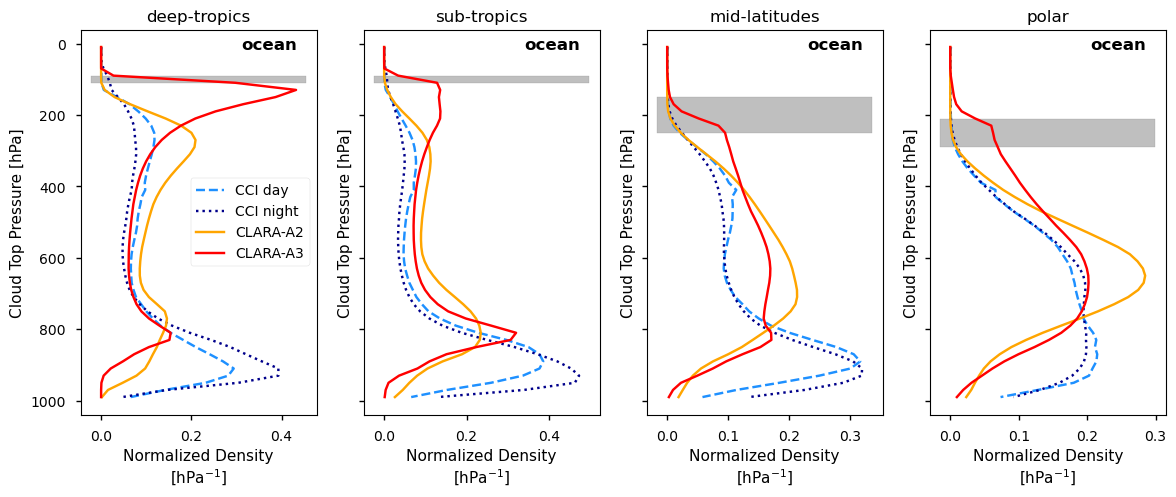

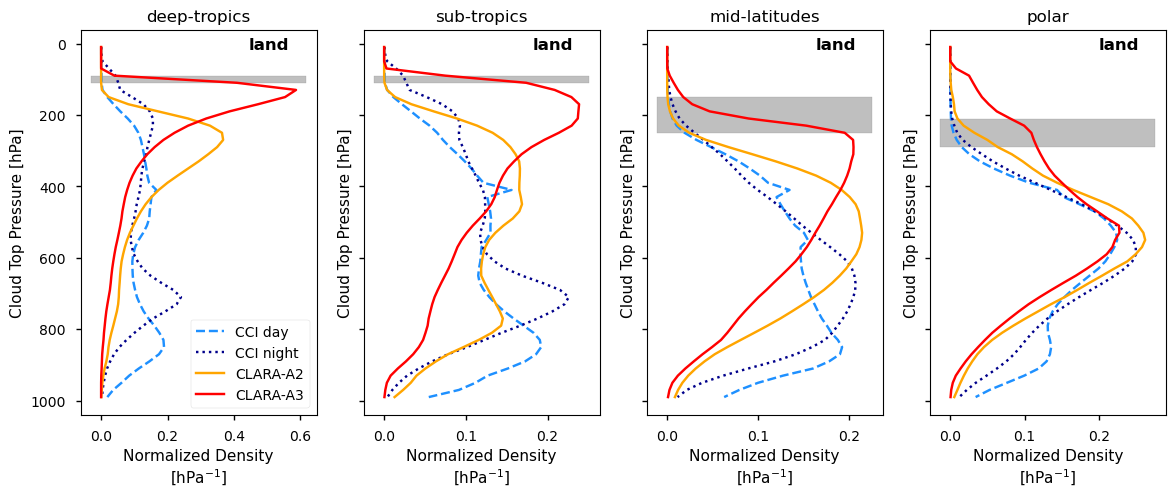

In [16]:
tropopause_level = {
    "deep-tropics": {"level": 100, "width": 10},
    "sub-tropics": {"level": 100, "width": 10},
    "mid-latitudes": {"level": 200, "width": 50},
    "polar": {"level": 250, "width": 40},
}

for mask in ["ocean", "land"]:
    fig, axs = plt.subplots(1, len(latitude_slices), figsize=(14, 5), sharey=True)
    for ax, region in zip(axs, list(latitude_slices)):
        for product, ds in distributions.items():
            for suffix in ("", "day", "night"):
                name = f"ctp_{suffix}" if suffix else "ctp"
                if name not in ds:
                    continue
                da = ds[name].sel(mask=mask, region=region)
                label = f"{product} {suffix}" if suffix else product
                da.plot(
                    ax=ax, y="bin", yincrease=False, label=label, **plot_kwargs[label]
                )
        # Add level
        level = tropopause_level[region]["level"]
        width = tropopause_level[region]["width"]
        ax.fill_between(
            ax.get_xlim(),
            [level - width] * 2,
            [level + width] * 2,
            color="gray",
            alpha=0.5,
        )
        # Labels
        ax.set_title(region)
        ax.text(
            0.8,
            0.96,
            mask,
            transform=ax.transAxes,
            fontsize=12,
            weight="bold",
            ha="center",
            va="center",
        )
    axs[0].legend()

_**Figure 1:** Normalized cloud-top pressure distributions over ocean (top) and over land (bottom), separately for deep-tropics, sub-tropics, mid-latitudes and polar regions during the period of interest. Compared are results derived from CLARA-A2, CLARA-A3 and CCI (day and night). Tropopause levels (depending on season) are shown as gray bands. The tropopause shifts from about 100 hPa (~17 km) in the tropics to 250 hPa (~9 km) in the polar regions._

Figure 1 compares normalized cloud-top pressure distributions derived from CLARA-A3, the earlier version CLARA-A2 and the CCI dataset (the lseparately day and night). These normalized distributions provide a top-down view of cloud tops and do not account for cloud layers hidden beneath the uppermost layer. While several features are consistent across the three datasets, notable differences are also apparent. In the following, these distributions are compared with results from the updated GEWEX cloud assessment [[1]](https://doi.org/10.1007/s10712-024-09824-0) to place the Climate Data Store (CDS) products in a broader context of existing satellite cloud estimates.

According to Figure 6 of [[1]](https://doi.org/10.1007/s10712-024-09824-0), cloud-top pressure distributions over oceans exhibit a bimodal structure in tropical and subtropical regions, with pronounced peaks in the upper and lower troposphere. These peaks weaken toward the polar regions. Over land, single-layer low-level clouds contribute only weakly. In addition, the cloud tops of high-level clouds gradually descend toward the poles, following the tropopause. Cloud-top pressure derived from active lidar observations (CALIPSO) corresponds to the physical cloud top, whereas passive remote sensing estimates represent a 'radiative' cloud height located below the cloud top. This difference is particularly pronounced for clouds with diffuse upper boundaries, which are common in the tropics [[2]](https://doi.org/10.1029/94JD02430).

The CLARA-A3 dataset reproduces the two distinct peaks in cloud density over tropical and subtropical oceans, associated with high- and low-level clouds. These peaks are more pronounced and narrower - especially in the high troposphere - than those obtained from radiative-transfer-based passive retrievals. Over land, CLARA-A3 shows a clear peak of high-level clouds in the tropics, which becomes less distinct toward polar latitudes as mid-level clouds become more prevalent. Because the CLARA-A3 cloud-top pressure retrieval is based on a neural network trained on CALIPSO cloud data, high-level cloud peaks in the tropics and subtropics closely match those derived from lidar. At polar latitudes, however, the CLARA-A3 distributions still exhibit a single mid-tropospheric peak, and over polar land a non-negligible fraction of clouds above the tropopause. In addition, low-level cloud height appears to be slightly overestimated compared to CALIPSO (850 hPa).

The earlier CLARA-A2 version, which relies on radiative-transfer-based retrievals, also captures the bimodal cloud structure over tropical and subtropical oceans. These peaks merge into a single mid-tropospheric maximum toward the poles. Over land, high-altitude cloud peaks dominate in the tropics and become broader and shift downwoard at higher latitudes. Compared to the CALIPSO peak for high-level clouds (around 150 hPa in the tropics), the CLARA-A2 radiative cloud-top pressure peak is located about 100 hPa lower (at 250 hPa). As in CLARA-A3, low-level cloud heights are slightly overestimated (around 800 instead of 850 hPa). It should be noted that the CLARA-A2 version shown in [[1]](https://doi.org/10.1007/s10712-024-09824-0) is earlier than the version in the CDS (versions 2.0 and 2.1, respectively).

The CCI product provides cloud-top pressure separately for daytime and nighttime. Over oceans, both show similar distributions, with slightly fewer high-level and more low-level clouds at night. Over land, nighttime distributions exhibit a modest increase in high-level clouds, while the low-level peak shifts from about 900 hPa during daytime to around 700 hPa at night. Overall, the CCI cloud-top distributions differ substantially from those of the CLARA datasets and from those inferred from comparable instruments in the updated GEWEX cloud assessment [[1]](https://doi.org/10.1007/s10712-024-09824-0). In particular, CCI strongly underestimates the relative occurrence of high-level clouds and overestimates low-level clouds over both land and ocean, especially in tropical and mid-latitude regions. The expected high-altitude peak in the tropics is nearly absent. In this sense, the CCI cloud top pressure distributions show the weakest consistency with GEWEX and CALIPSO among the evaluated products.


#### Cloud top pressure uncertainty

In this subsection, we compare the CCI and CLARA-A3 uncertainty estimates for the gridded daily-mean cloud top pressures. Both datasets provide different estimates of the uncertainty:

1) the average footprint retrieval uncertainty,

2) the grid cell uncertainty, assuming a correlation of 0.1 between footprint uncertainties to acknowledge that the retrieval errors have some shared component (e.g. from calibration, forward radiative transfer model, assumed atmosphere). This uncertainty is in general larger than the grid-mean uncertainty, but smaller than the average footprint retrieval uncertainty. The latter two are different by a factor of 1/sqrt(N), with N the number of cloudy footprints within the grid cell.

We use the grid cell cloud-top uncertainty, as we have used the grid cell averages of the cloud top pressure in Figure 1. For the CCI dataset, the uncertainty, as the cloud-top pressure, is provided separately for daytime and nighttime. In the following, we compare distributions of these uncertainties separately for high-level (cloud top pressure < 440 hPa) and for low-level clouds (cloud top pressure > 680 hPa), for the same latitude bands over ocean and over land, as the cloud top pressure distributions displayed in Figure 1.

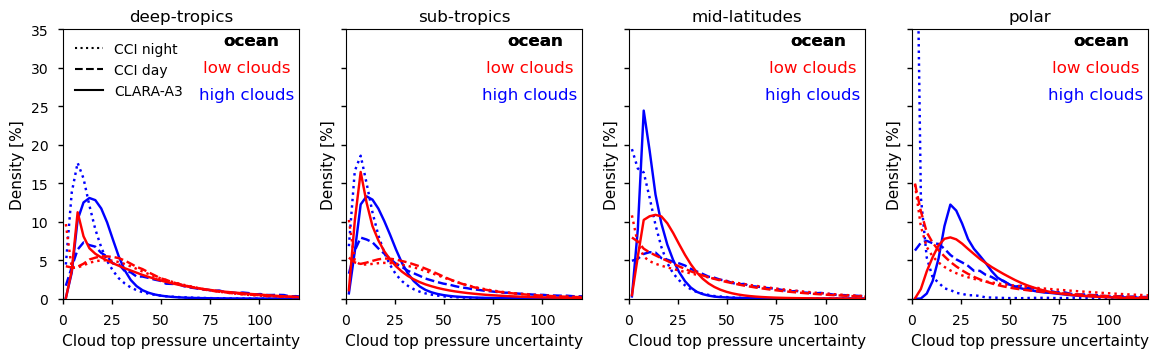

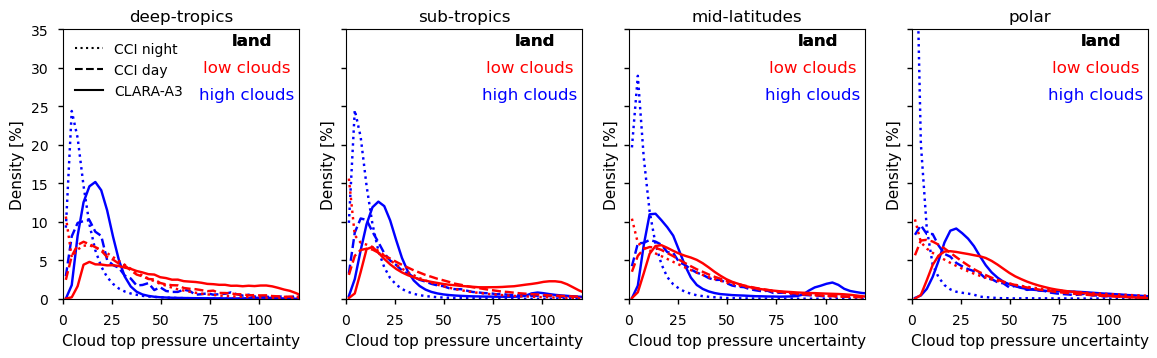

In [21]:
for mask in ["ocean", "land"]:
    fig, axs = plt.subplots(1, len(latitude_slices), figsize=(14, 3.5), sharey=True)
    for idx, clouds in enumerate (["high", "low"]):
        for ax, region in zip(axs, list(latitude_slices)):
            for product, ds in uncertanties.items():
                label = product
                match product:
                    case "CCI":
                        label_CCI_night = Line2D([0], [0], color="k", lw=1.5, ls=":")
                        name = "ctp_night_cor"  
                        label = product + " night"
                        label = label + " " + clouds
                        da = ds[name].sel(mask=mask, region=region, clouds=clouds)
                        da.plot(ax=ax, x="bin", **plot_kwargs[label])

                        label_CCI_day = Line2D([0], [0], color="k", lw=1.5, ls="--")
                        name_day = "ctp_day_cor"  
                        label = product + " " + "day"
                        label = label + " " + clouds
                        da_day = ds[name_day].sel(mask=mask, region=region, clouds=clouds)
                        da_day.plot(ax=ax, x="bin", **plot_kwargs[label])
                        
                    case "CLARA-A3":
                        label_CLARAA3 = Line2D([0], [0], color="k", lw=1.5, ls="-")
                        name = "ctp_unc01"
                        label = label + " " + clouds
                        da = ds[name].sel(mask=mask, region=region, clouds=clouds)
                        da.plot(ax=ax, x="bin", **plot_kwargs[label])
                
                    case _:
                        raise NotImplementedError(f"{product=}")
                
            # Labels
            ax.set_xlim(0,120)
            ax.set_ylim(0,35)
            ax.set_title(region)
            ax.text(
                0.8,
                0.96,
                mask,
                transform=ax.transAxes,
                fontsize=12,
                weight="bold",
                ha="center",
                va="center",
            )
            if idx == 0 :
                ax.text(
                    0.78,
                    0.76,
                    clouds + " clouds",
                    transform=ax.transAxes,
                    fontsize=12,
                    color="blue",
                    ha="center",
                    va="center",
                )
            else :
                ax.text(
                0.78,
                0.86,
                clouds + " clouds",
                transform=ax.transAxes,
                fontsize=12,
                color="red",
                ha="center",
                va="center",
            )
            custom_labels = [label_CCI_night,label_CCI_day, label_CLARAA3]
            axs[0].legend(custom_labels, ["CCI night","CCI day","CLARA-A3"],loc ='best', frameon=False)

_**Figure 2:** Distribution of cloud-top pressure uncertainty for high-level and low-level clouds over ocean (top) and over land (bottom), in the by deep tropics, subtropics, mid-latitudes, and polar regions during the period of interest. The presented maximum density in the plots is limited to 35%, while CCI night high-level cloud top pressure uncertainty reaches 60 to 70% in the polar regions._

In general, the cloud-top pressure uncertainty distributions are broader for low-level clouds than for high-level clouds. For CLARA-A3, uncertainties are larger over land than over ocean, particularly for low-level clouds. In the CCI dataset, uncertainty distributions for high-level clouds are narrower during nighttime than during daytime, reflecting the additional use of visible channels during day, while uncertainties for low-level clouds are similar between day and night. 

For high-level clouds, uncertainty distributions peak around 10-20 hPa for CLARA-A3 and around 2-10 hPa for CCI, with uncertainties exceeding 50 hPa being negligible (except CCI during daytime). In CLARA-A3, these distributions broaden toward polar regions, as expected, whereas CCI uncertainties are smallest in polar regions.

For low-level clouds, uncertainty distributions generally peak at slightly lower values than thoses of high-level clouds but are much broader overall, especially over land. A secondary peak around 110 hPa over subtropical land arises from grid cells containing only a small number of cloudy observations. In contrast, CCI uncertainty distributions frequently peak near 0 hPa, which appears unrealistic.

Taken together with the cloud-top pressure distributions - where CCI identifies far fewer high-level clouds tahn other datasets - the very small uncertainties for CCI high-level clouds suggest that this product primarily identifies cases with intrinsically low uncertainty, such as high opaque clouds.

## ℹ️ If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used is:
- [__Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations__](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview)

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)


The GEWEX Cloud Assessment:
- The Global Energy and Water Exchanges (GEWEX) program is a core project of the World Climate Research Programme (WCRP). The first GEWEX Cloud Assessment was published in 2012 and it provided the first coordinated inter-comparison of publicly available, global
cloud products [[3](https://doi.org/10.1175/BAMS-D-12-00117.1)-[4](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf)]. The database associated with the GEWEX Cloud Assessment
has revealed its usefulness for the assessment of new datasets. Since in the last decade existing
cloud property retrievals have been revised and new retrievals have been developed, this exercise has been recently repeated with 11 global cloud products derived from measurements of multi-spectral imagers, IR sounders, and lidar [[1]](https://doi.org/10.1007/s10712-024-09824-0). The first cloud assessment included products from ATSR, while the most recent assessment includes CLARA-A2. However, the CLARA-A2 version (V2.1) in the CDS is a later, improved version compared to the one provided in the updated GEWEX cloud assessment (V2.0). The updated cloud assessment database is available at [this link](https://gewexca.aeris-data.fr/).


### Reference/Useful material

[[1]](https://doi.org/10.1007/s10712-024-09824-0) Stubenrauch, C.J., Kinne, S., Mandorli, G. et al. Lessons Learned from the Updated GEWEX Cloud Assessment Database. Surv Geophys (2024). https://doi.org/10.1007/s10712-024-09824-0

[[2]](https://doi.org/10.1029/94JD02430) Liao, X., W. B. Rossow, and D. Rind (1995), Comparison between SAGE II and ISCCP high-level clouds: 2. Locating cloud tops, J. Geophys. Res., 100(D1), 1137–1147, doi:10.1029/94JD02430. 

[[3]](https://doi.org/10.1175/BAMS-D-12-00117.1) Stubenrauch, C. J., and Coauthors, 2013: Assessment of Global Cloud Datasets from Satellites: Project and Database Initiated by the GEWEX Radiation Panel. Bull. Amer. Meteor. Soc., 94, 1031–1049, https://doi.org/10.1175/BAMS-D-12-00117.1 

[[4]](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf) Stubenrauch CJ, Rossow WB, Kinne S, GEWEX Cloud Assessment Team (2012) Assessment of Global Cloud Datasets from Satellites, A Project of the World Climate Research Programme Global Energy and Water Cycle Experiment (GEWEX) Radiation Panel, WCRP report.
